In [1]:
import os 
os.chdir('../')
from PIL import Image 
from arguments import parser 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
from datasets import create_dataset 
from torch.utils.data import DataLoader
from utils.metrics import MetricCalculator, loco_auroc
from accelerate import Accelerator
from omegaconf import OmegaConf
import seaborn as sns 
from main import torch_seed
from collections import OrderedDict

from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

torch_seed(42)
exp_dir = '/Volume/VAD/LifeLongerAD_cu121/results/CFGCAD/MVTecAD/baseline6_200epoch-3_5_with_5_step-Continual_True-online_False/seed_42/'
cfg_dir = os.path.join(exp_dir,'configs.yaml')
cfg = OmegaConf.load(cfg_dir)


model  = __import__('models').__dict__[cfg.MODEL.method](
        backbone = cfg.MODEL.backbone,
        **cfg.MODEL.params
        ).to('cuda')
device = 'cuda'


loader_dict = {}
accelerator = Accelerator()
for cn in cfg.DATASET.class_names:
    trainset, testset = create_dataset(
        dataset_name  = cfg.DATASET.dataset_name,
        datadir       = cfg.DATASET.datadir,
        class_name    = cn,
        img_size      = cfg.DATASET.img_size,
        mean          = cfg.DATASET.mean,
        std           = cfg.DATASET.std,
        aug_info      = cfg.DATASET.aug_info,
        **cfg.DATASET.get('params',{})
    )
    trainloader = DataLoader(
        dataset     = trainset,
        batch_size  = cfg.DATASET.batch_size,
        num_workers = cfg.DATASET.num_workers,
        shuffle     = True 
    )    

    testloader = DataLoader(
            dataset     = testset,
            batch_size  = 2,
            num_workers = cfg.DATASET.num_workers,
            shuffle     = False 
        )    
    
    loader_dict[cn] = {'train':trainloader,'test':testloader}    


In [2]:
from copy import deepcopy 
model_before = deepcopy(model).cuda() 
cn = cfg.DATASET.class_names[0]
model_weight = os.path.join(exp_dir,'model_weight',f'{cn}_model.pth')
weight = torch.load(model_weight)
model.load_state_dict(weight)    
model = model.cuda()

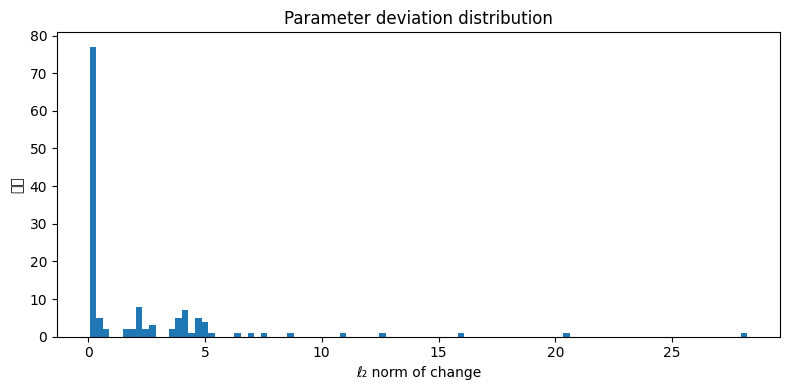

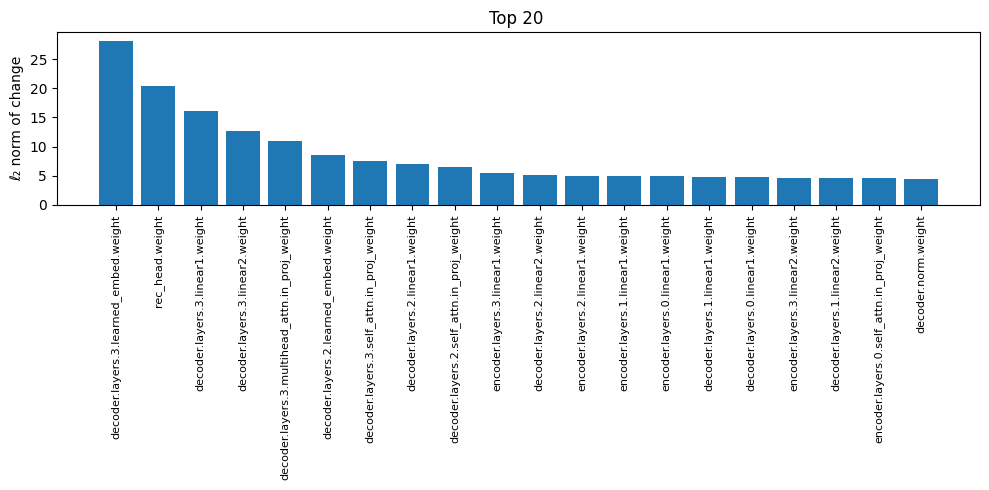

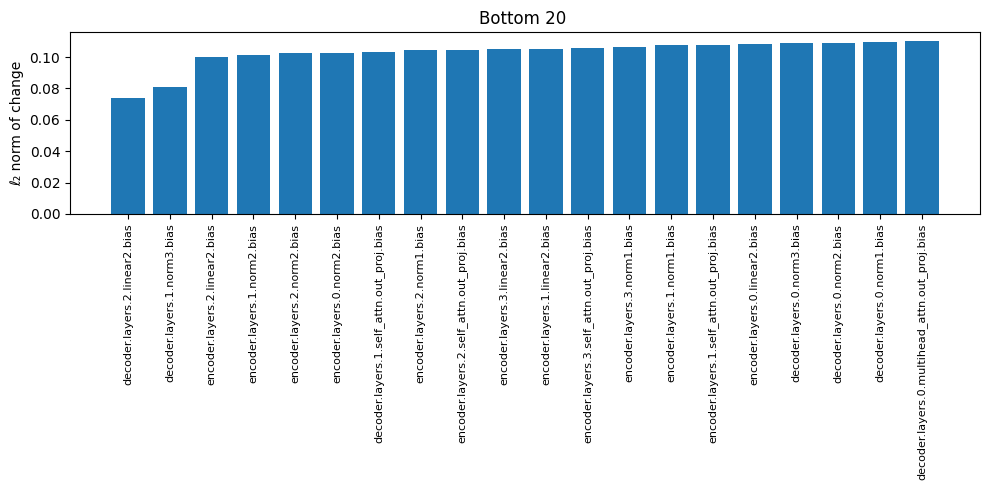

In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compute_param_changes(state_before, state_after):
    """
    두 state_dict 간 동일한 키의 파라미터 차이를 ℓ₂ 노름으로 계산
    - floating-point 텐서만 처리
    - 반환: {param_name: change_value}
    """
    changes = {}
    for name, p_before in state_before.items():
        # 1) 같은 이름의 텐서 가져오기
        p_after = state_after[name]
        # 2) 부동소수점 텐서가 아니면 건너뛰기 (e.g., num_batches_tracked)
        if not p_before.is_floating_point():
            continue
        # 3) float으로 변환한 뒤 차이의 ℓ₂ 노름 계산
        diff = (p_after.float() - p_before.float()).view(-1)
        changes[name] = torch.norm(diff, p=2).item()
    return changes

# — 예시 사용법 —
# model_before, model_after 는 같은 아키텍처의 학습 전/후 모델
state_before = model_before.reconstruction.state_dict()
state_after  = model.reconstruction.state_dict()

# 파라미터 변화량 계산
changes = compute_param_changes(state_before, state_after)
# 상위 N개 파라미터 바 차트
N = 20
topN = sorted(changes.items(), key=lambda x: x[1], reverse=True)[:N]
names, vals = zip(*topN)
names = [n.replace('reconstruction.', '').replace('transformer.','') for n in names]
plt.figure(figsize=(10,5))
plt.bar(range(N), vals)
plt.xticks(range(N), names, rotation=90, fontsize=8)
plt.title(f"Top {N} ")
plt.ylabel("ℓ₂ norm of change")
plt.tight_layout()
plt.show()

# 상위 N개 파라미터 바 차트
N = 20
topN = sorted(changes.items(), key=lambda x: x[1], reverse=False)[:N]
names, vals = zip(*topN)
names = [n.replace('reconstruction.', '').replace('transformer.','') for n in names]
plt.figure(figsize=(10,5))
plt.bar(range(N), vals)
plt.xticks(range(N), names, rotation=90, fontsize=8)
plt.title(f"Bottom {N} ")
plt.ylabel("ℓ₂ norm of change")
plt.tight_layout()
plt.show()


In [39]:
from copy import deepcopy 

model  = __import__('models').__dict__[cfg.MODEL.method](
        backbone = cfg.MODEL.backbone,
        **cfg.MODEL.params
        ).to('cuda')


model_before = deepcopy(model).cuda() 
cn = cfg.DATASET.class_names[4]
model_weight = os.path.join(exp_dir,'model_weight',f'{cn}_model.pth')
weight = torch.load(model_weight)
model.load_state_dict(weight)    
model = model.cuda()

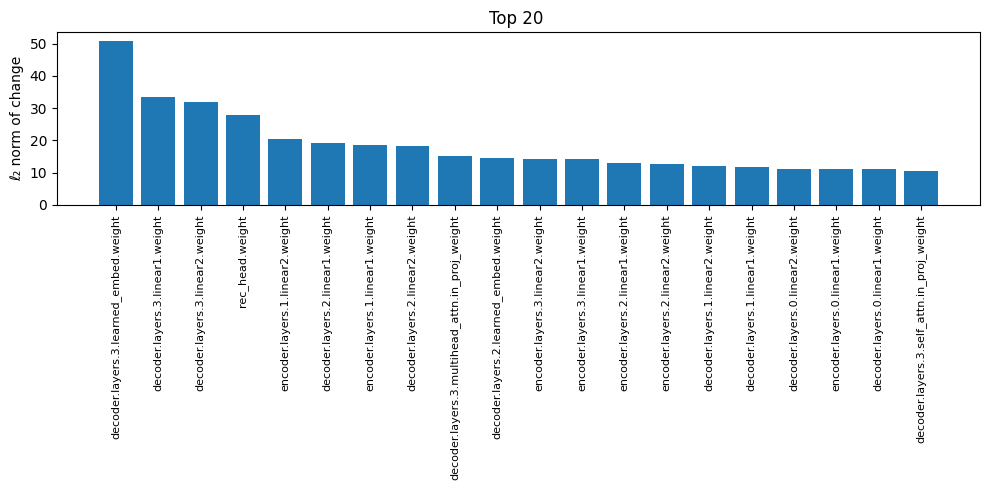

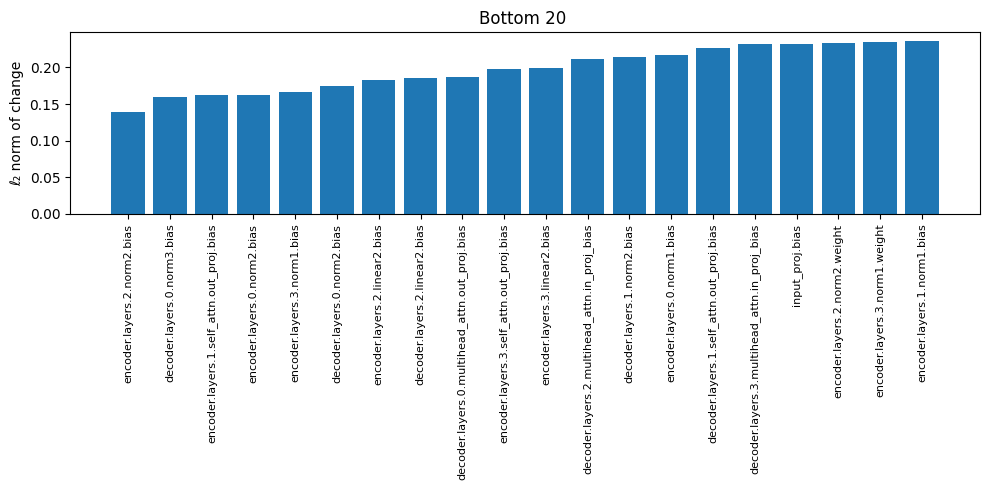

In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compute_param_changes(state_before, state_after):
    """
    두 state_dict 간 동일한 키의 파라미터 차이를 ℓ₂ 노름으로 계산
    - floating-point 텐서만 처리
    - 반환: {param_name: change_value}
    """
    changes = {}
    for name, p_before in state_before.items():
        # 1) 같은 이름의 텐서 가져오기
        p_after = state_after[name]
        # 2) 부동소수점 텐서가 아니면 건너뛰기 (e.g., num_batches_tracked)
        if not p_before.is_floating_point():
            continue
        # 3) float으로 변환한 뒤 차이의 ℓ₂ 노름 계산
        diff = (p_after.float() - p_before.float()).view(-1)
        changes[name] = torch.norm(diff, p=2).item()
    return changes

# — 예시 사용법 —
# model_before, model_after 는 같은 아키텍처의 학습 전/후 모델
state_before = model_before.reconstruction.state_dict()
state_after  = model.reconstruction.state_dict()

# 파라미터 변화량 계산
changes = compute_param_changes(state_before, state_after)
# 상위 N개 파라미터 바 차트
N = 20
topN = sorted(changes.items(), key=lambda x: x[1], reverse=True)[:N]
names, vals = zip(*topN)
names = [n.replace('reconstruction.', '').replace('transformer.','') for n in names]
plt.figure(figsize=(10,5))
plt.bar(range(N), vals)
plt.xticks(range(N), names, rotation=90, fontsize=8)
plt.title(f"Top {N} ")
plt.ylabel("ℓ₂ norm of change")
plt.tight_layout()
plt.show()

# 상위 N개 파라미터 바 차트
N = 20
topN = sorted(changes.items(), key=lambda x: x[1], reverse=False)[:N]
names, vals = zip(*topN)
names = [n.replace('reconstruction.', '').replace('transformer.','') for n in names]
plt.figure(figsize=(10,5))
plt.bar(range(N), vals)
plt.xticks(range(N), names, rotation=90, fontsize=8)
plt.title(f"Bottom {N} ")
plt.ylabel("ℓ₂ norm of change")
plt.tight_layout()
plt.show()


In [ ]:
from copy import deepcopy 

model  = __import__('models').__dict__[cfg.MODEL.method](
        backbone = cfg.MODEL.backbone,
        **cfg.MODEL.params
        ).to('cuda')


model_before = deepcopy(model).cuda() 
cn = cfg.DATASET.class_names[4]
model_weight = os.path.join(exp_dir,'model_weight',f'{cn}_model.pth')
weight = torch.load(model_weight)
model.load_state_dict(weight)    
model = model.cuda()

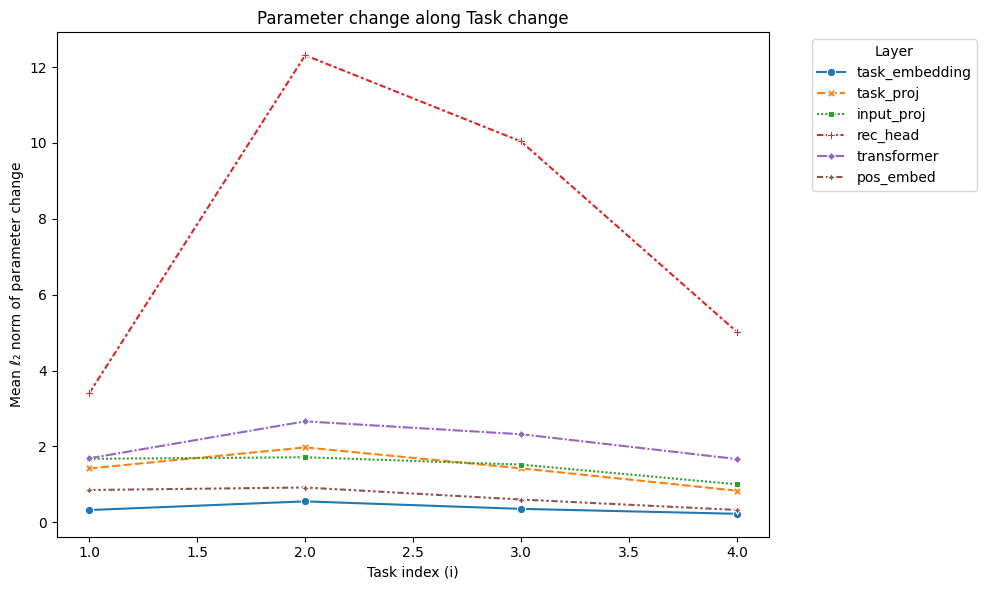

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compute_param_changes(state_before, state_after):
    """floating-point 텐서만 ℓ2 노름 계산, reconstruction.* 만 반환"""
    changes = {}
    for name, p_before in state_before.items():
        # 1) reconstruction 내부 파라미터만
        if not name.startswith('reconstruction.'):
            continue
        # 2) floating-point 체크
        if not p_before.is_floating_point():
            continue
        # 3) 변화량 계산
        p_after = state_after[name]
        diff = (p_after.float() - p_before.float()).view(-1)
        changes[name] = torch.norm(diff, p=2).item()
    return changes

# 1) 각 Task checkpoint 로드
tasks = [0, 1, 2, 3, 4]
states = {}
for i, task in enumerate(tasks):
    cn = cfg.DATASET.class_names[i]
    path = os.path.join(exp_dir, 'model_weight', f'{cn}_model.pth')
    states[task] = torch.load(path)

# 2) Task변경 구간별—레이어별 변화량 평균 계산
records = []
for i in tasks[1:]:
    before = states[i-1]
    after  = states[i]
    # reconstruction.* 만 남긴 상태에서 변화 계산
    changes = compute_param_changes(before, after)

    # layer 추출: reconstruction.encoder.layers.2.self_attn.in_proj.weight → encoder.layers.2
    def layer_of(name):
        parts = name.split('.')[1:]  # ['encoder','layers','2',...]
        if parts[0] in ('encoder','decoder'):
            return f"{parts[0]}.{parts[1]}.{parts[2]}"
        else:
            return parts[0]

    # grouping & 평균
    layer_vals = {}
    for name, val in changes.items():
        layer = layer_of(name)
        layer_vals.setdefault(layer, []).append(val)

    avg_per_layer = {layer: np.mean(vals) for layer, vals in layer_vals.items()}
    avg_per_layer['task'] = i
    records.append(avg_per_layer)

# 3) DataFrame 생성
df = pd.DataFrame(records).set_index('task').sort_index()

# 4) 레이어별 변화량 lineplot
plt.figure(figsize=(10,6))
sns.lineplot(data=df, markers=True)
plt.title("Parameter change along Task change")
plt.xlabel("Task index (i)")
plt.ylabel("Mean ℓ₂ norm of parameter change")
plt.legend(title="Layer", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


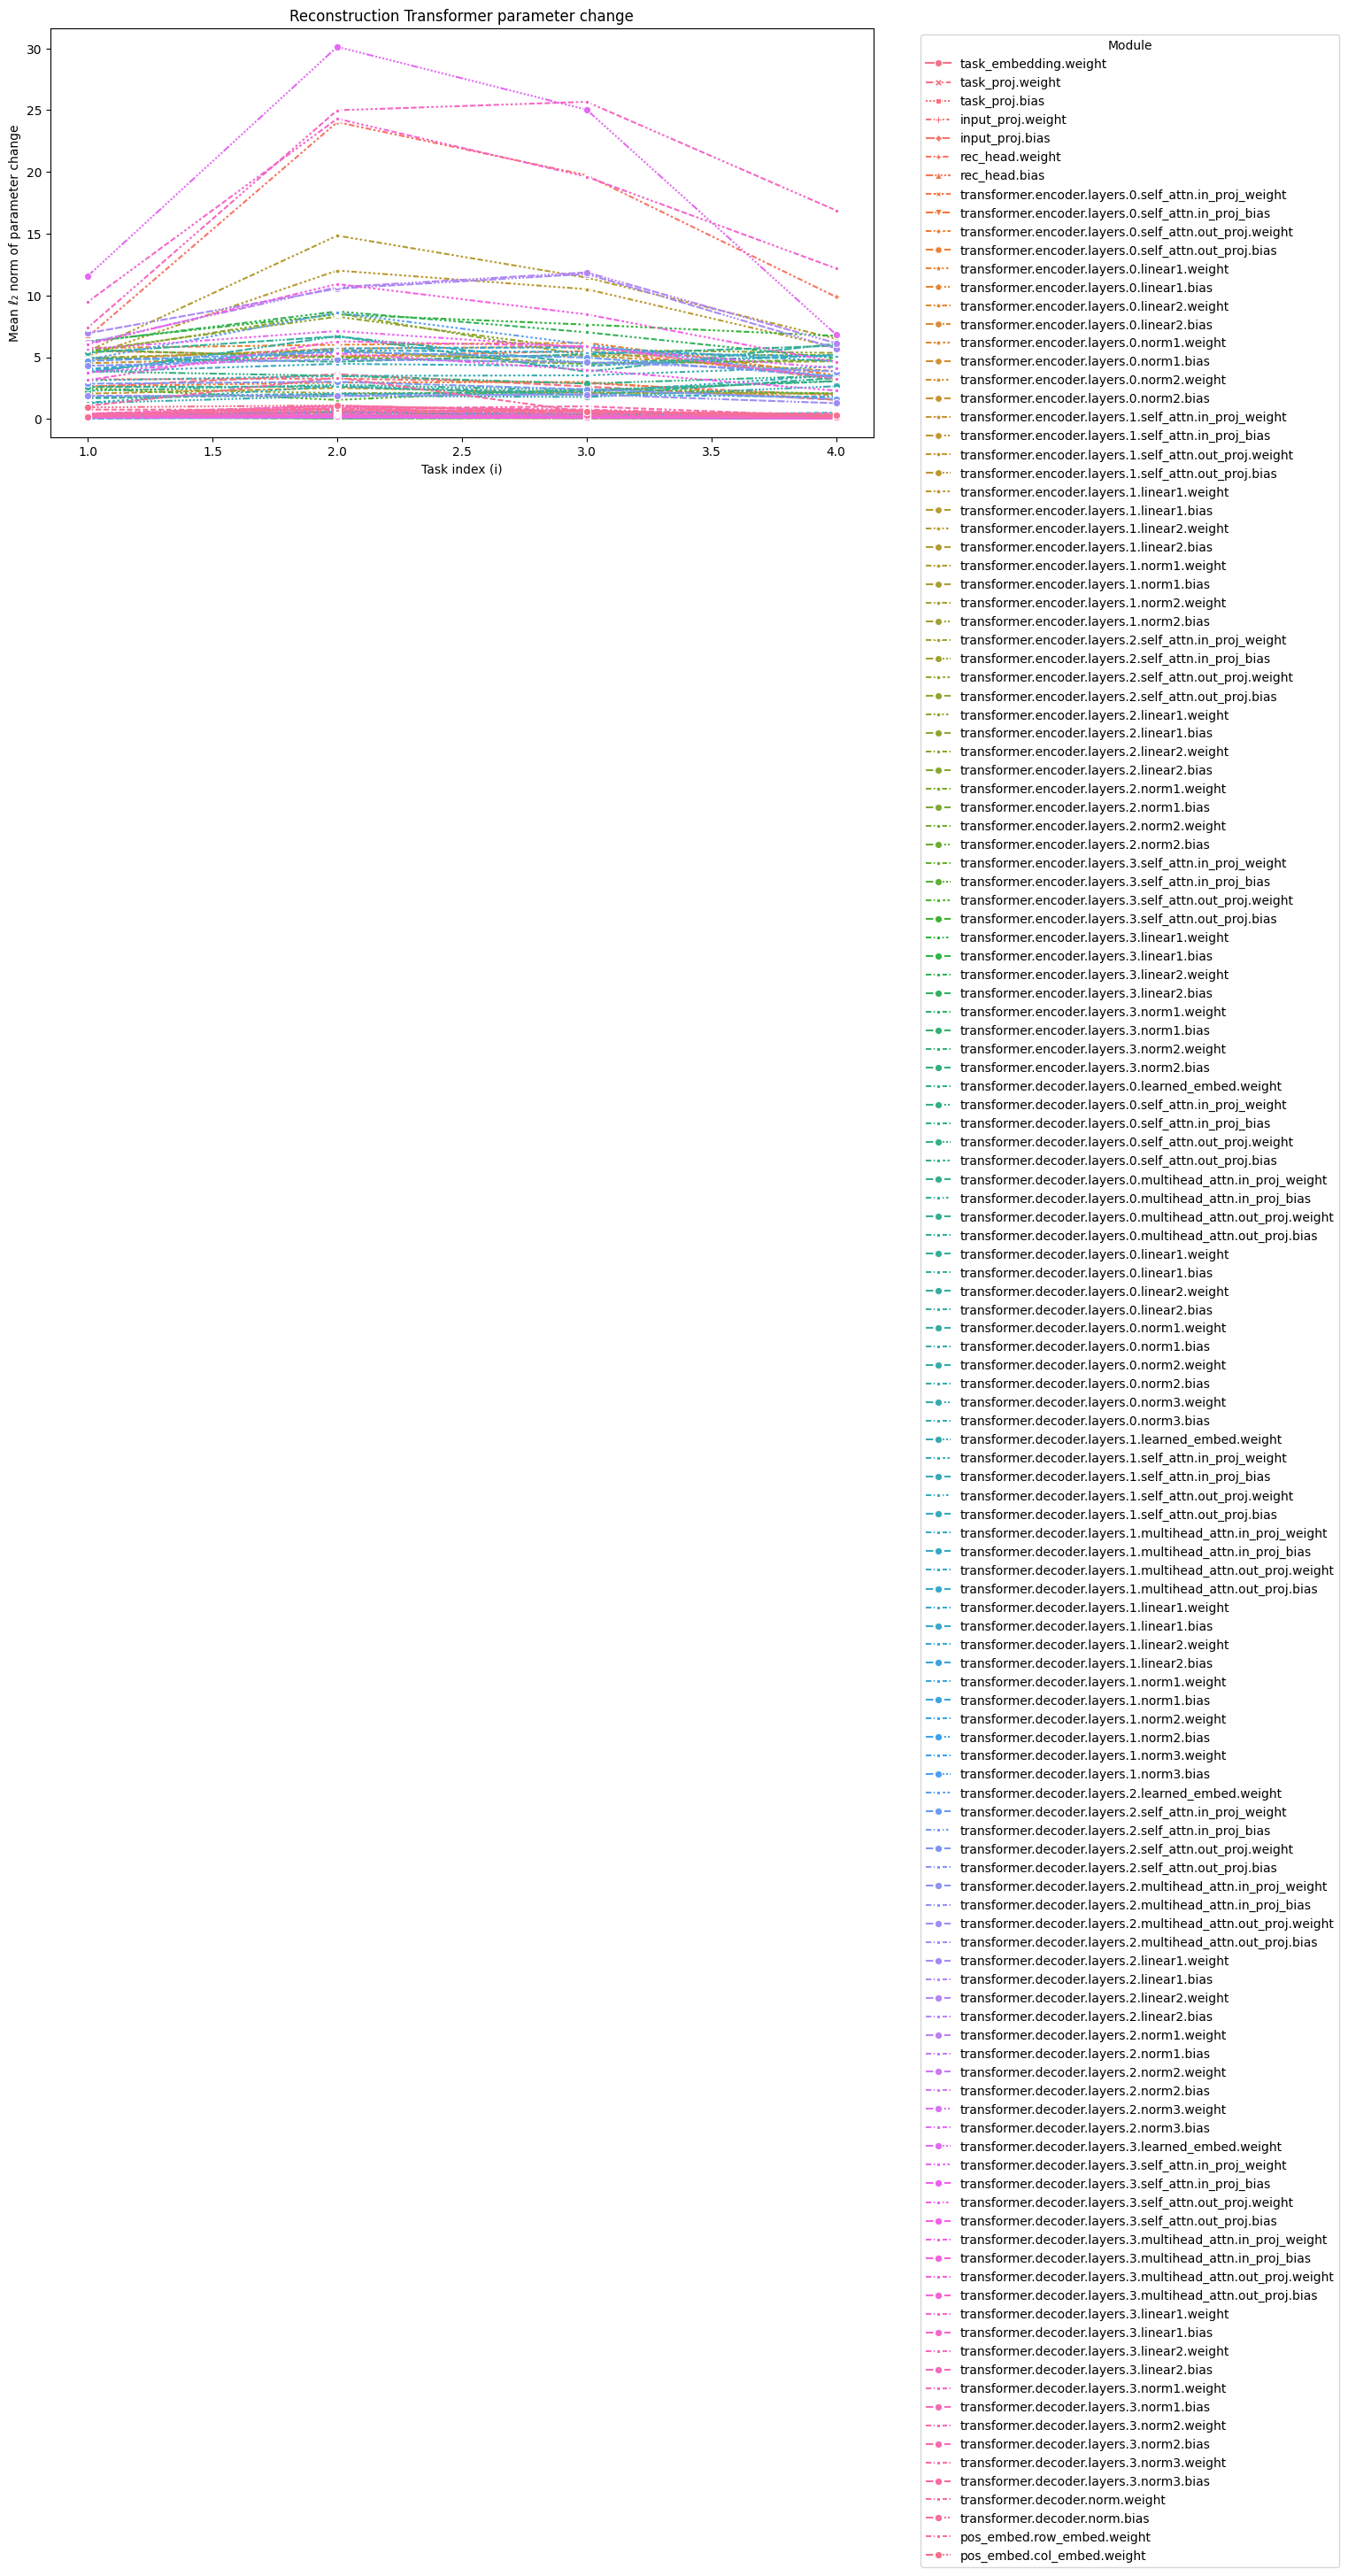

In [3]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compute_param_changes(state_before, state_after):
    """floating-point 텐서만 ℓ2 노름 계산, reconstruction.* 만 반환"""
    changes = {}
    for name, p_before in state_before.items():
        if not name.startswith('reconstruction.'):
            continue
        if not p_before.is_floating_point():
            continue
        p_after = state_after[name]
        diff = (p_after.float() - p_before.float()).view(-1)
        changes[name] = torch.norm(diff, p=2).item()
    return changes

# 1) 각 Task checkpoint 로드
tasks = [0, 1, 2, 3, 4]
states = {}
for i, task in enumerate(tasks):
    cn = cfg.DATASET.class_names[i]
    path = os.path.join(exp_dir, 'model_weight', f'{cn}_model.pth')
    states[task] = torch.load(path)

# 2) Task변경 구간별—Transformer 내부 모듈별 변화량 평균 계산
records = []
for i in tasks[1:]:
    before = states[i-1]
    after  = states[i]
    changes = compute_param_changes(before, after)

    # ▶ Transformer 내부 모듈 단위(group) 식별 함수
    def layer_of(name):
        # name 예시: reconstruction.encoder.layers.2.self_attn.in_proj.weight
        parts = name.split('.')[1:]  
        # parts = ['encoder','layers','2','self_attn','in_proj','weight']
        if parts[0] in ('encoder','decoder') and parts[1] == 'layers':
            module  = parts[3]              # self_attn / linear1 / linear2 / norm?    
            layerno = parts[2]              # e.g. '2'
            return f"{parts[0]}.layer{layerno}.{module}"
        else:
            # rec_head, input, multihead_attn 등은 그대로
            return '.'.join(parts)

    # grouping & 평균
    layer_vals = {}
    for name, val in changes.items():
        grp = layer_of(name)
        layer_vals.setdefault(grp, []).append(val)

    avg_per_group = {grp: np.mean(vals) for grp, vals in layer_vals.items()}
    avg_per_group['task'] = i
    records.append(avg_per_group)

# 3) DataFrame 생성
df = pd.DataFrame(records).set_index('task').sort_index()

# 4) 모듈별 lineplot
plt.figure(figsize=(12,6))
sns.lineplot(data=df, markers=True)
plt.title("Reconstruction Transformer parameter change")
plt.xlabel("Task index (i)")
plt.ylabel("Mean ℓ₂ norm of parameter change")
plt.legend(title="Module", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


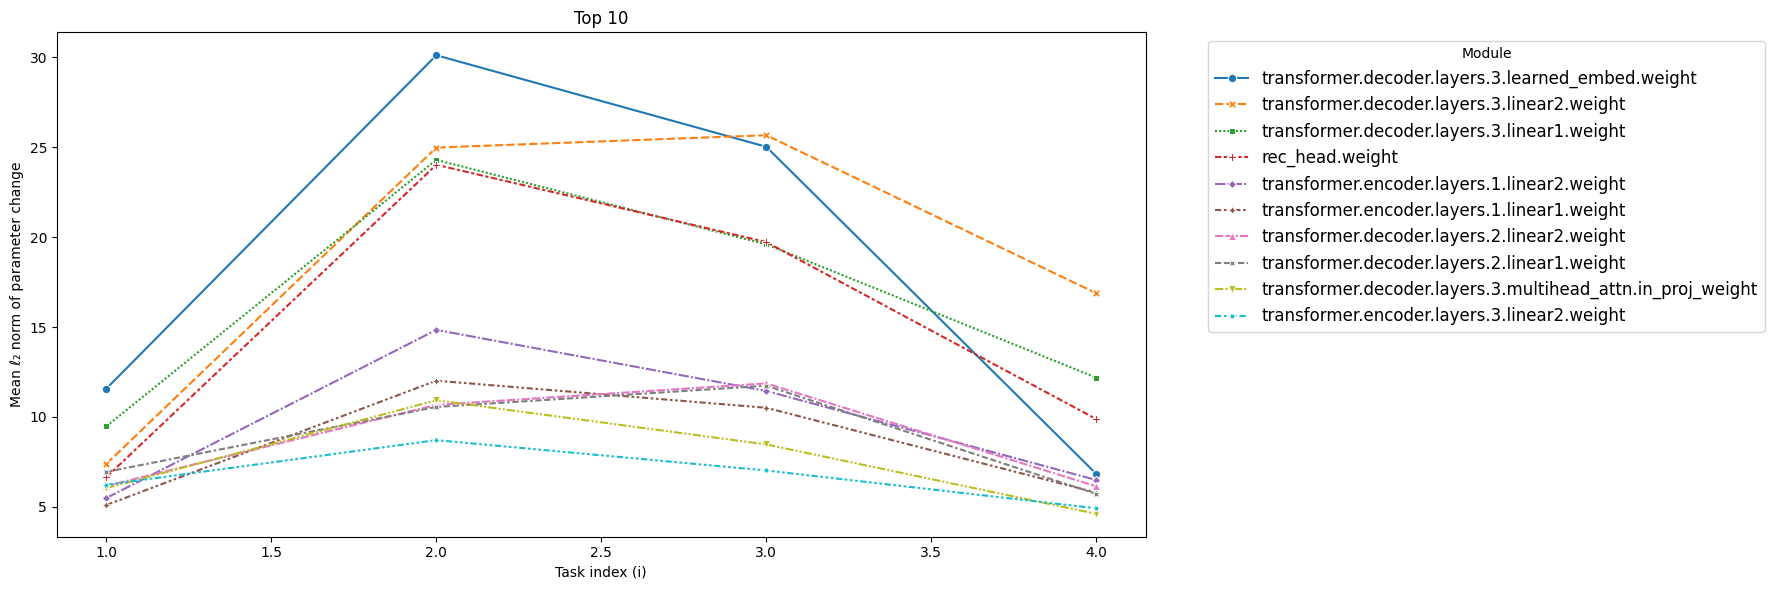

In [11]:
# … (앞의 compute_param_changes, 체크포인트 로딩, records 생성 코드는 동일)

# 3) DataFrame 생성
df = pd.DataFrame(records).set_index('task').sort_index()

# 4) 변화가 심한 모듈만 필터링
#    - 모듈별 최고 변화량을 구해서 상위 K개만 선택
K = 10
overall_max = df.max().sort_values(ascending=False)
top_modules = overall_max.head(K).index.tolist()

# 5) 상위 K개 모듈에 대해서만 라인플롯
plt.figure(figsize=(18,6))
sns.lineplot(data=df[top_modules], markers=True)
plt.title(f"Top {K}")
plt.xlabel("Task index (i)")
plt.ylabel("Mean ℓ₂ norm of parameter change")
plt.legend(title="Module", bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=12)
# plt.legend(title="Module", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


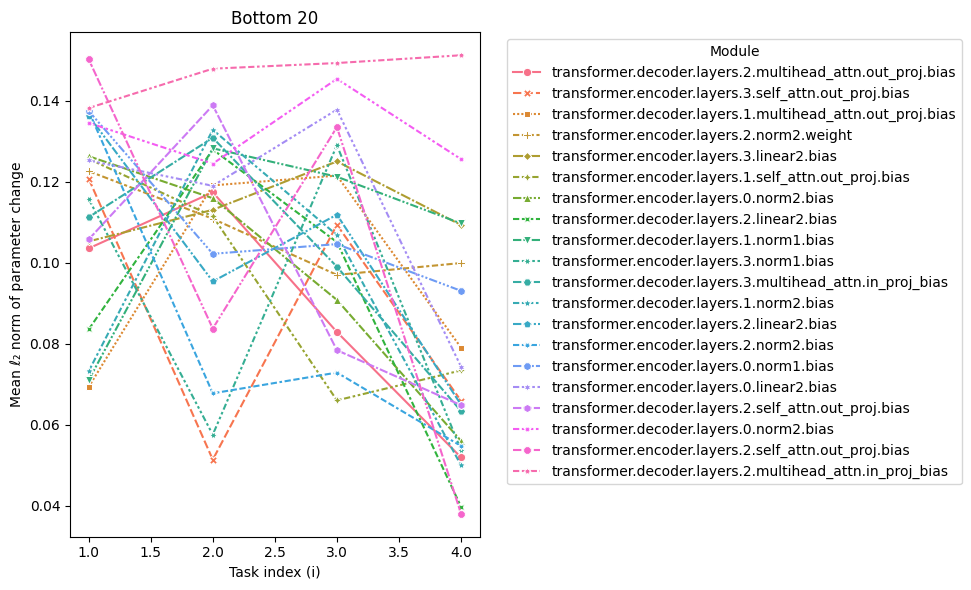

In [13]:
# … (앞의 compute_param_changes, 체크포인트 로딩, records 생성 코드는 동일)

# 3) DataFrame 생성
df = pd.DataFrame(records).set_index('task').sort_index()

# 4) 변화가 심한 모듈만 필터링
#    - 모듈별 최고 변화량을 구해서 상위 K개만 선택
K = 20
overall_max = df.max().sort_values(ascending=True)
top_modules = overall_max.head(K).index.tolist()

# 5) 상위 K개 모듈에 대해서만 라인플롯
plt.figure(figsize=(10,6))
sns.lineplot(data=df[top_modules], markers=True)
plt.title(f"Bottom {K}")
plt.xlabel("Task index (i)")
plt.ylabel("Mean ℓ₂ norm of parameter change")
plt.legend(title="Module", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


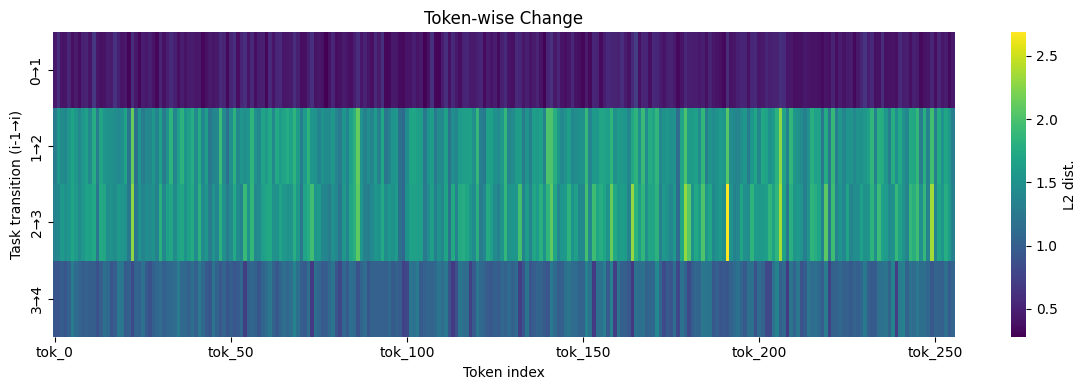

In [23]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Checkpoint 로드
tasks = [0,1,2,3,4]
states = {}
for i,task in enumerate(tasks):
    cn = cfg.DATASET.class_names[i]
    path = os.path.join(exp_dir, 'model_weight', f'{cn}_model.pth')
    states[task] = torch.load(path)

# 2) Token 단위 변화량 계산
token_changes = {}
for i in tasks[1:]:
    w_before = states[i-1]['reconstruction.transformer.decoder.layers.3.linear2.weight'].float()
    w_after  = states[i  ]['reconstruction.transformer.decoder.layers.3.linear2.weight'].float()
    diff = w_after - w_before
    row_norms = diff.norm(p=2, dim=1).cpu().numpy()
    token_changes[f"{i-1}→{i}"] = row_norms

# 3) DataFrame 생성
df_tokens = pd.DataFrame.from_dict(
    token_changes, orient='index',
    columns=[f"tok_{j}" for j in range(row_norms.shape[0])]
)

# ⭐ 4) 임계값 필터링: 1.5 미만은 0으로 치환
threshold = 0
df_filtered = df_tokens.mask(df_tokens < threshold, 0)

# 5) Heatmap 시각화
plt.figure(figsize=(12, 4))
sns.heatmap(
    df_filtered,
    cmap='viridis',
    cbar_kws={'label': 'L2 dist.'},
    xticklabels=50,
    yticklabels=True
)
plt.xlabel("Token index")
plt.ylabel("Task transition (i-1→i)")
plt.title("Token-wise Change")
plt.tight_layout()
plt.show()


In [31]:
model  = __import__('models').__dict__[cfg.MODEL.method](
        backbone = cfg.MODEL.backbone,
        **cfg.MODEL.params
        ).to('cuda')

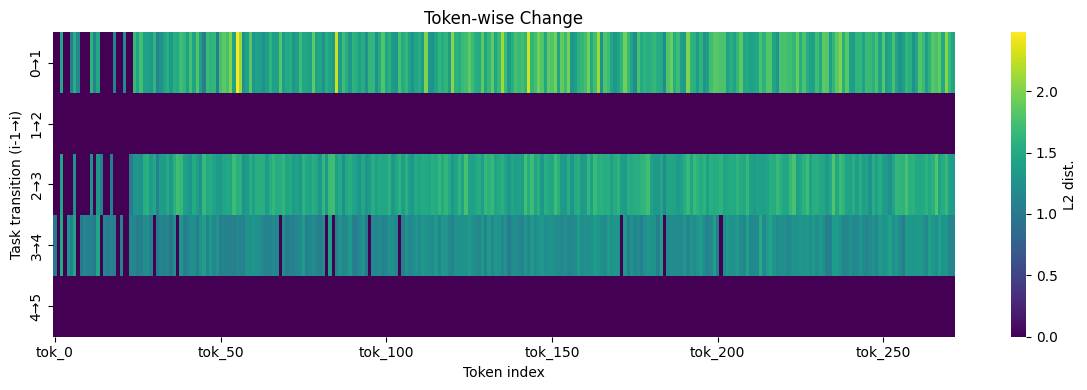

In [37]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Checkpoint 로드
tasks = [0,1,2,3,4,5]
states = {}
for i,task in enumerate(tasks):
    if i == 0 :
        states[task] = model.state_dict()
    else:
        i = i-1
        cn = cfg.DATASET.class_names[i]
        path = os.path.join(exp_dir, 'model_weight', f'{cn}_model.pth')
        states[task] = torch.load(path)

# 2) Token 단위 변화량 계산
token_changes = {}
for i in tasks[1:]:
    w_before = states[i-1]['reconstruction.rec_head.weight'].float()
    w_after  = states[i  ]['reconstruction.rec_head.weight'].float()
    diff = w_after - w_before
    row_norms = diff.norm(p=2, dim=1).cpu().numpy()
    token_changes[f"{i-1}→{i}"] = row_norms

# 3) DataFrame 생성
df_tokens = pd.DataFrame.from_dict(
    token_changes, orient='index',
    columns=[f"tok_{j}" for j in range(row_norms.shape[0])]
)

# ⭐ 4) 임계값 필터링: 1.5 미만은 0으로 치환
threshold = 1
df_filtered = df_tokens.mask(df_tokens < threshold, 0)

# 5) Heatmap 시각화
plt.figure(figsize=(12, 4))
sns.heatmap(
    df_filtered,
    cmap='viridis',
    cbar_kws={'label': 'L2 dist.'},
    xticklabels=50,
    yticklabels=True
)
plt.xlabel("Token index")
plt.ylabel("Task transition (i-1→i)")
plt.title("Token-wise Change")
plt.tight_layout()
plt.show()
